In [32]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Datetime cleaning

## Drop irrelevant years

In [ ]:
df = pd.read_parquet('yellow_tripdata_2022-01.parquet')

In [55]:
# drop irrelevant years
df['year'] = df['tpep_pickup_datetime'].apply(lambda x: x.year)
df.drop(df[df['year'] != 2022].index, axis=0, inplace=True)
df.drop('year', axis=1, inplace=True)

In [56]:
# data formats
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2463893 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

## Get the target variable

In [57]:
# trip duration
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()

## Drop non-positive trip durations

In [58]:
df.drop(df[df['trip_duration'] <= 0].index, axis=0, inplace=True)

In [59]:
# summary statistics for trip duration
round(df['trip_duration'].describe(percentiles=[.01, .015, .02, .05, .1, .2, .25, .5, .75, .8, .9, .95, .98, .99, .998]), 2)

count    2461444.00
mean         853.49
std         2782.45
min            1.00
1%            46.00
1.5%          89.00
2%           112.00
5%           179.00
10%          242.00
20%          336.00
25%          380.00
50%          611.00
75%          970.00
80%         1087.00
90%         1479.00
95%         1916.00
98%         2529.00
99%         3051.00
99.9%      49815.63
max       510791.00
Name: trip_duration, dtype: float64

In [60]:
df.drop(df[df['trip_duration'] < 120].index, axis=0, inplace=True)
df.drop(df[df['trip_duration'] >= df['trip_duration'].quantile(0.998)].index, axis=0, inplace=True)

In [61]:
round(df['trip_duration'].describe(), 2)

count    2402151.00
mean         777.89
std          566.80
min          120.00
25%          394.00
50%          622.00
75%          979.00
max         4706.00
Name: trip_duration, dtype: float64

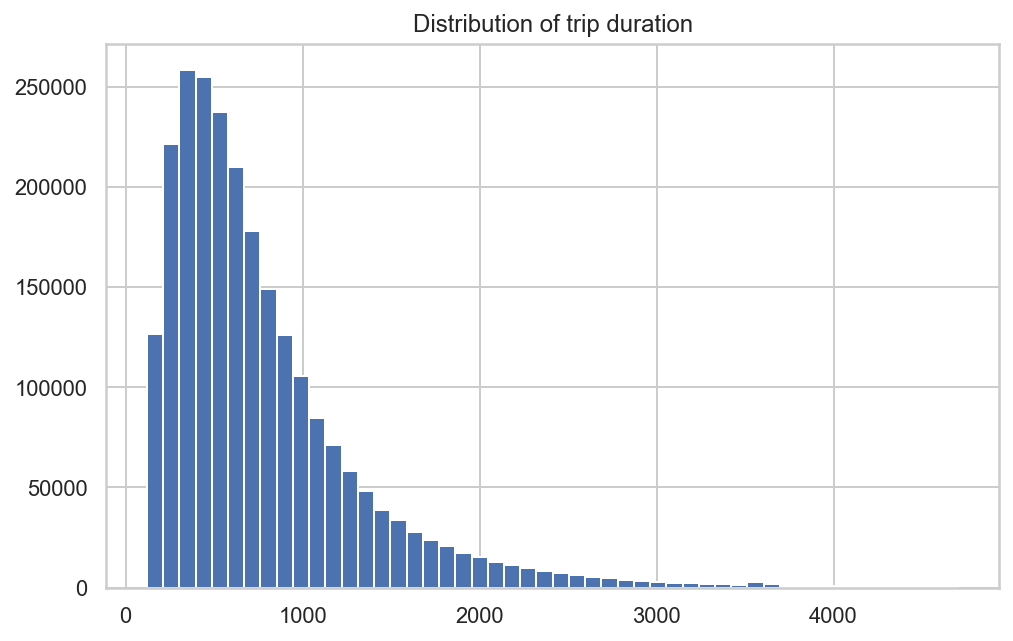

In [66]:
# trip duration histogram
plt.hist(df['trip_duration'], bins=50)
plt.title('Distribution of trip duration')
plt.show()

In [64]:
# log trip duration
df['log_trip_duration'] = np.log1p(df['trip_duration'])

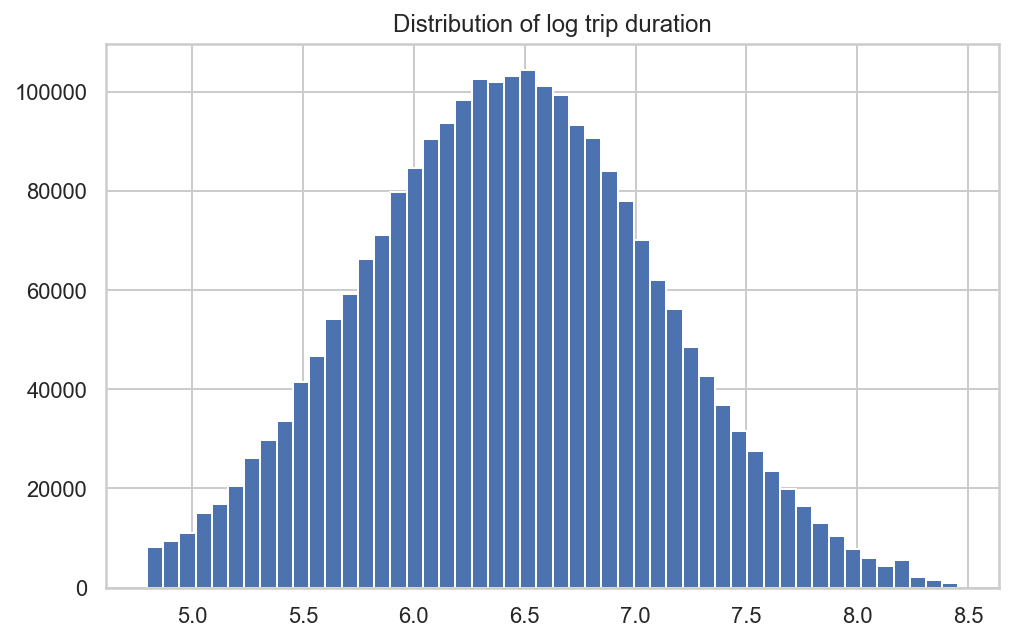

In [65]:
# log trip duration histogram
plt.hist(df['log_trip_duration'], bins=50)
plt.title('Distribution of log trip duration')
plt.show()

<Figure size 720x432 with 0 Axes>

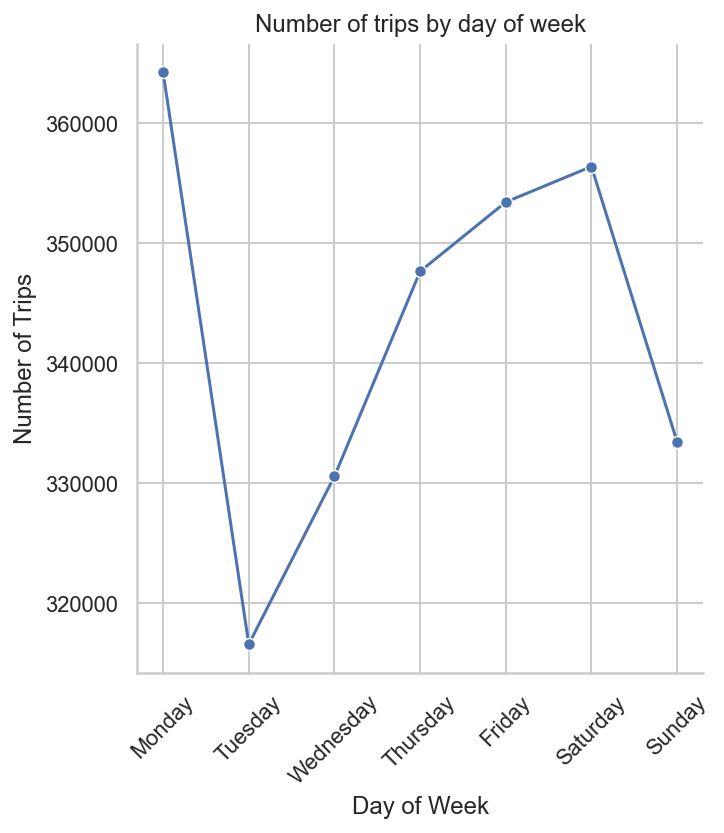

In [67]:
# number of trips vs day of week
# Extract day of week from the timestamp
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()

# Count the number of trips for each day of the week
trip_counts = df['day_of_week'].value_counts().sort_index()

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'day_of_week': trip_counts.index, 'trip_count': trip_counts.values})

# Order days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot_df['day_of_week'] = pd.Categorical(plot_df['day_of_week'], categories=days_order, ordered=True)

# Create the plot using seaborn
plt.figure(figsize=(10, 6))
plot = sns.relplot(x='day_of_week', y='trip_count', kind='line', data=plot_df, marker='o')

# Set plot labels and title
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.title('Number of trips by day of week')
plt.xticks(rotation=45)

# Show the plot
plt.show()

<Figure size 720x432 with 0 Axes>

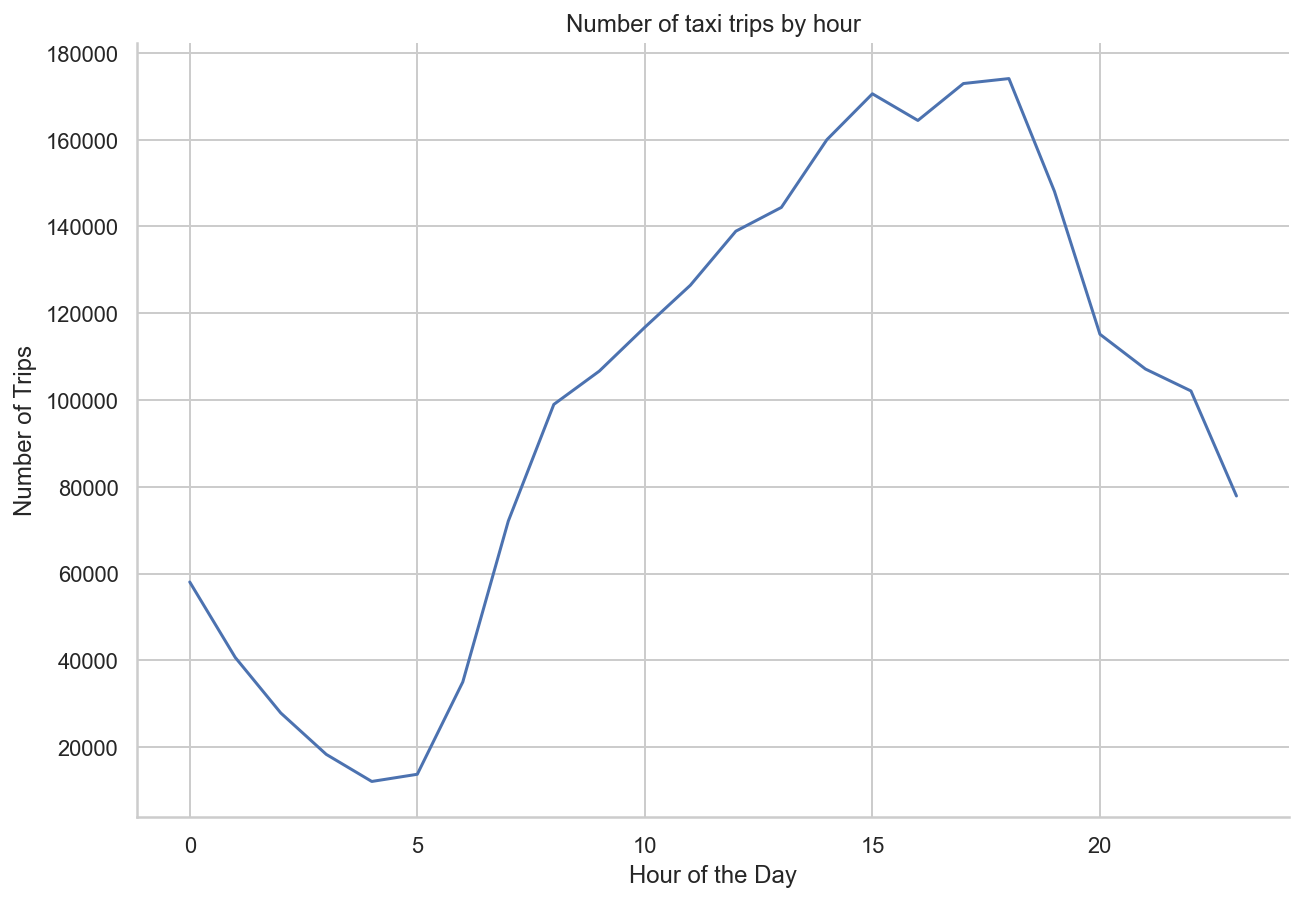

In [68]:
# number of trips vs hour
# Extract the hour from the timestamp
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

# Count the number of trips for each hour
hourly_counts = df['pickup_hour'].value_counts().sort_index()

# Create a DataFrame from the counts
hourly_df = pd.DataFrame({'Hour': hourly_counts.index, 'Trips': hourly_counts.values})

# Set the plotting style
sns.set(style="whitegrid")

# Create the relplot
plt.figure(figsize=(10, 6))
plot = sns.relplot(x='Hour', y='Trips', kind='line', data=hourly_df, sort=True, height=6, aspect=1.5)

# Set plot labels and title
plot.set(xlabel='Hour of the Day', ylabel='Number of Trips', title='Number of taxi trips by hour')

# Display the plot
plt.show()

<Figure size 864x432 with 0 Axes>

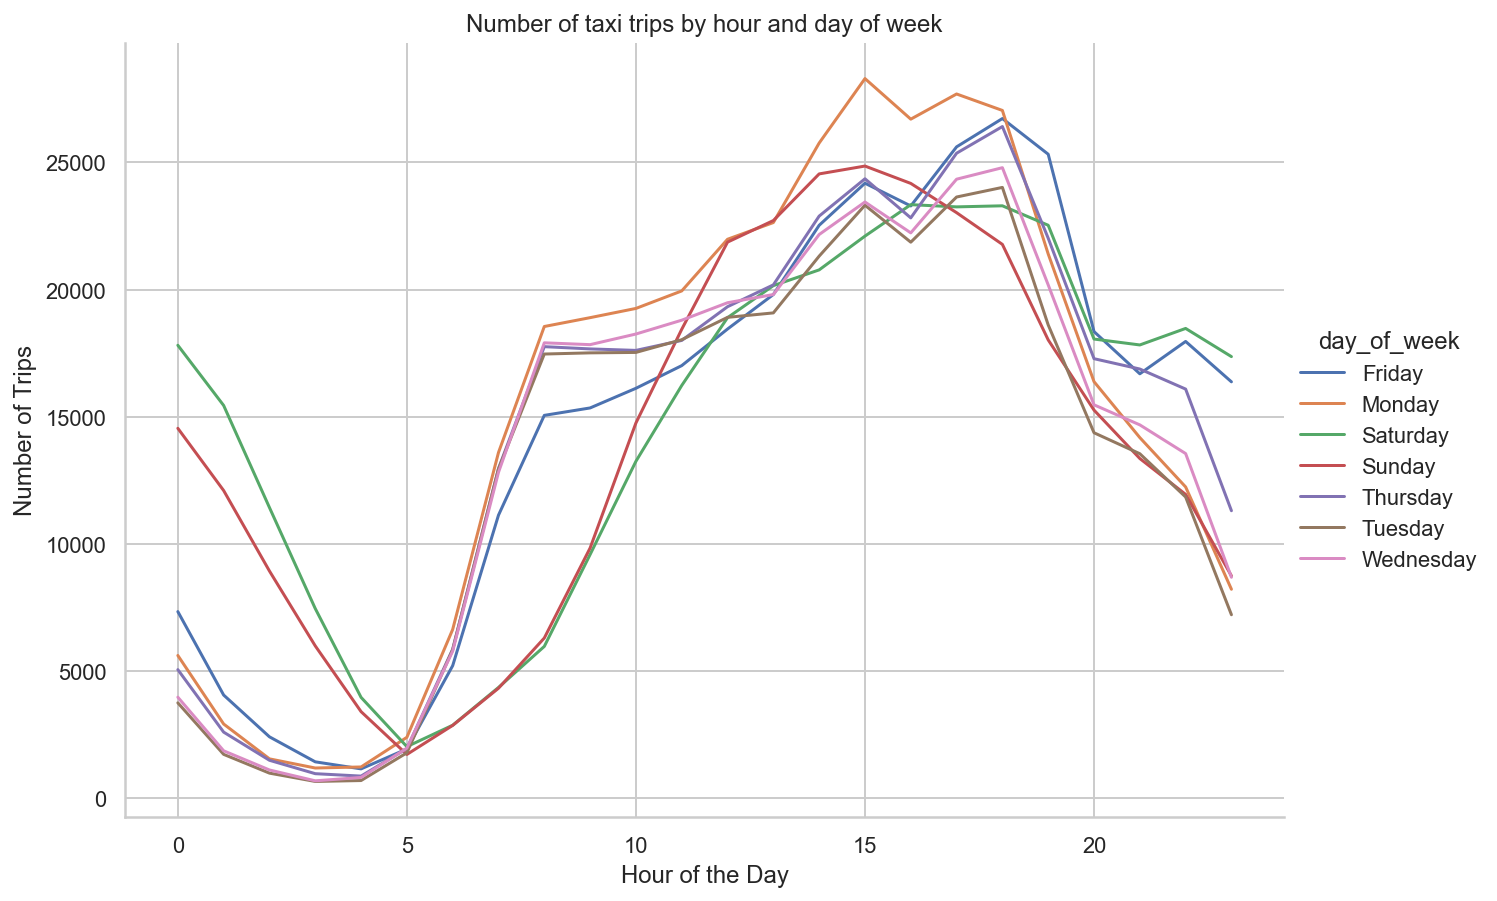

In [69]:
# number of trips vs hour for different days of week

# Extract the hour and day of the week from the timestamp
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()

# Count the number of trips for each hour and day of the week
hourly_counts = df.groupby(['day_of_week', 'pickup_hour']).size().reset_index(name='Trips')

# Set the plotting style
sns.set(style="whitegrid")

# Create the relplot
plt.figure(figsize=(12, 6))
plot = sns.relplot(x='pickup_hour', y='Trips', hue='day_of_week', kind='line', data=hourly_counts, sort=True, height=6, aspect=1.5)

# Set plot labels and title
plot.set(xlabel='Hour of the Day', ylabel='Number of Trips', title='Number of taxi trips by hour and day of week')

# Display the plot
plt.show()


<Figure size 864x432 with 0 Axes>

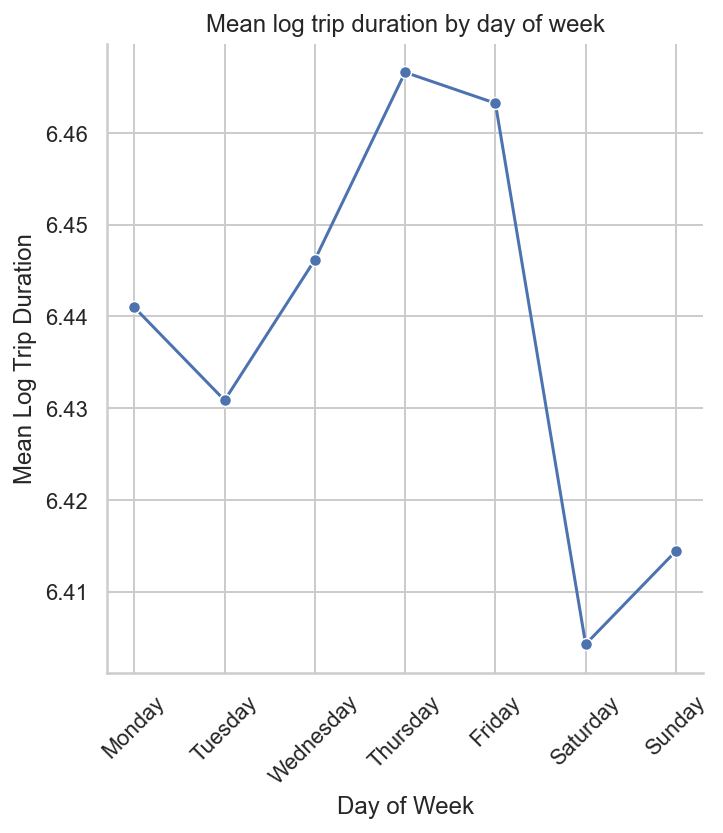

In [70]:
# mean log trip duration vs day of week

# Extract day of the week and create a new column
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()

# Group by day of the week and calculate the mean log trip duration
mean_duration_by_day = df.groupby('day_of_week')['log_trip_duration'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Create a relplot using seaborn
sns.set(style="whitegrid")  # Set the style if needed
plt.figure(figsize=(12, 6))  # Set the figure size if needed

# Use relplot to create the plot
plot = sns.relplot(x=mean_duration_by_day.index, y=mean_duration_by_day.values, kind='line', marker='o', sort=False)

# Set labels and title
plt.xlabel('Day of Week')
plt.ylabel('Mean Log Trip Duration')
plt.title('Mean log trip duration by day of week')

# Set the logical order for the days of the week
plot.set_xticklabels(rotation=45)

# Show the plot
plt.show()

<Figure size 864x432 with 0 Axes>

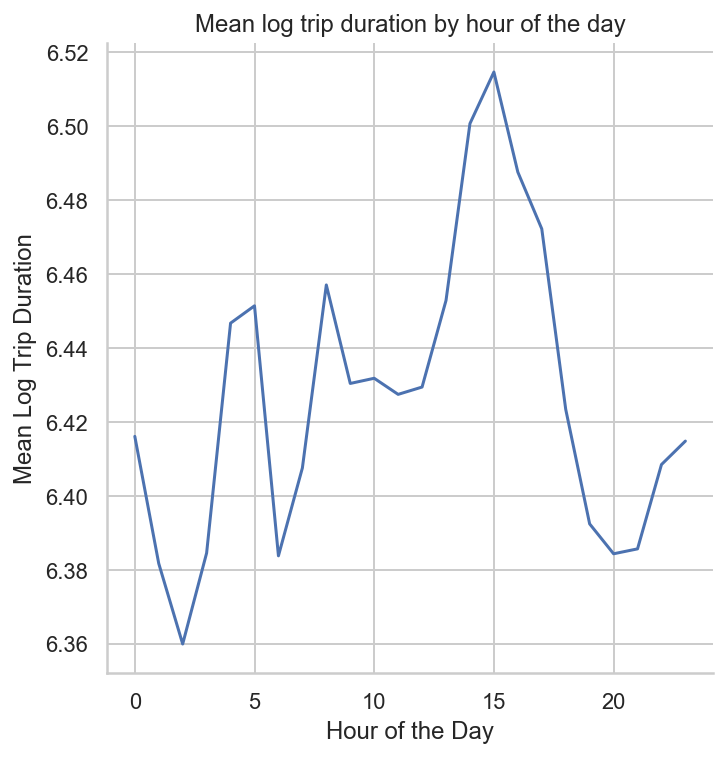

In [71]:
# mean log trip duration vs hour

# Extract the hour of the day from 'tpep_pickup_datetime'
df['hour_of_day'] = df['tpep_pickup_datetime'].dt.hour

# Create a new DataFrame with mean log trip duration for each hour of the day
mean_duration_by_hour = df.groupby('hour_of_day')['log_trip_duration'].mean().reset_index()

# Plot the data using sns.relplot()
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plot = sns.relplot(x='hour_of_day', y='log_trip_duration', kind='line', data=mean_duration_by_hour)

# Set plot labels and title
plot.set(xlabel='Hour of the Day', ylabel='Mean Log Trip Duration', title='Mean log trip duration by hour of the day')

# Show the plot
plt.show()

<Figure size 864x432 with 0 Axes>

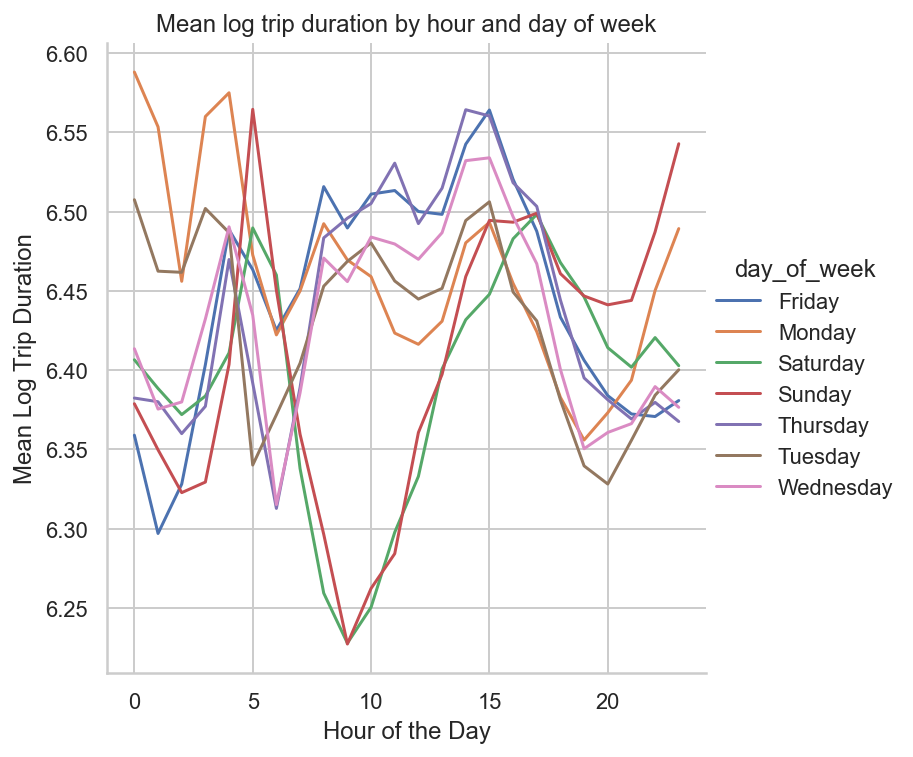

In [72]:
# mean log trip duration vs hour for different days of week

# Convert 'tpep_pickup_datetime' to datetime format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Extract the hour of the day and day of the week from 'tpep_pickup_datetime'
df['hour_of_day'] = df['tpep_pickup_datetime'].dt.hour
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()

# Create a new DataFrame with mean log trip duration for each day of the week and hour of the day
mean_duration_by_hour_and_day = df.groupby(['day_of_week', 'hour_of_day'])['log_trip_duration'].mean().reset_index()

# Plot the data using sns.relplot() with 'hue' parameter
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plot = sns.relplot(x='hour_of_day', y='log_trip_duration', kind='line', hue='day_of_week', data=mean_duration_by_hour_and_day)

# Set plot labels and title
plot.set(xlabel='Hour of the Day', ylabel='Mean Log Trip Duration', title='Mean log trip duration by hour and day of week')

# Show the plot
plt.show()

In [84]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'trip_duration',
       'log_trip_duration', 'day_of_week', 'pickup_hour', 'hour_of_day',
       'log_trip_distance', 'mean_velocity'],
      dtype='object')

New features: `hour_of_day`, `day_of_week`

TODO: `day_of_year`

# Trip distance

In [73]:
df['log_trip_distance'] = np.log1p(df['trip_distance'])
df['log_trip_distance'].corr(df['log_trip_duration'])

0.8201588225591486

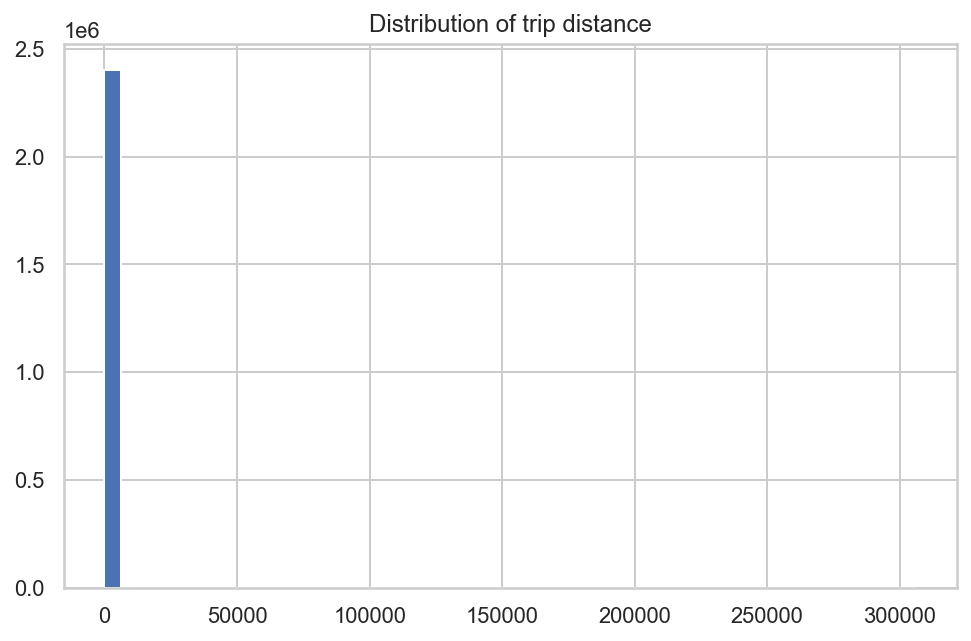

In [77]:
# trip distance histogram
plt.hist(df['trip_distance'], bins=50)
plt.title('Distribution of trip distance')
plt.show()

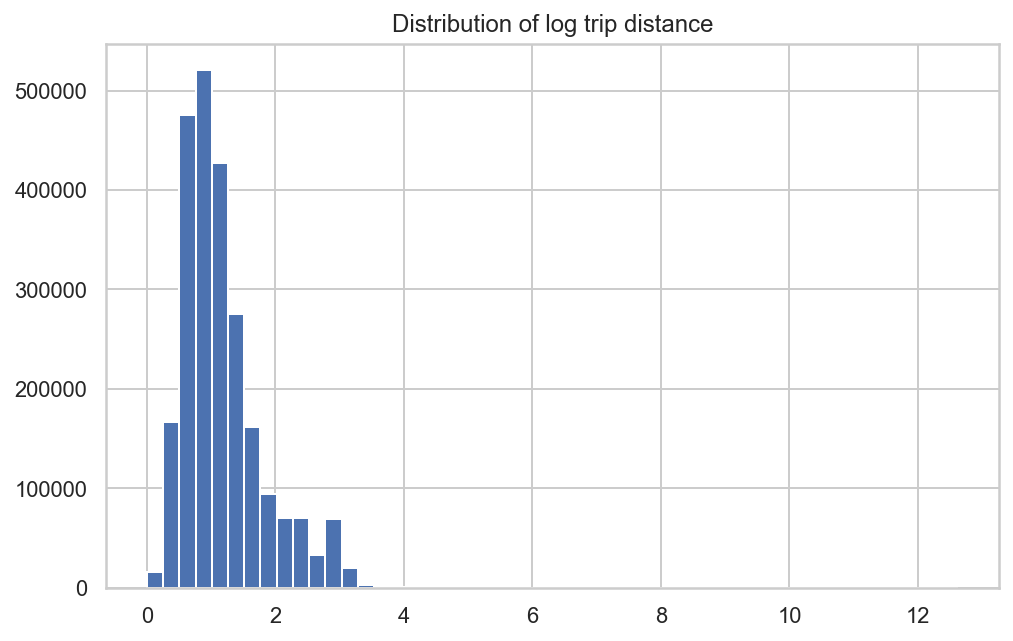

In [80]:
# log trip distance histogram
plt.hist(df['log_trip_distance'], bins=50)
plt.title('Distribution of log trip distance')
plt.show()

In [74]:
df['mean_velocity'] = df['trip_distance'] / df['trip_duration']

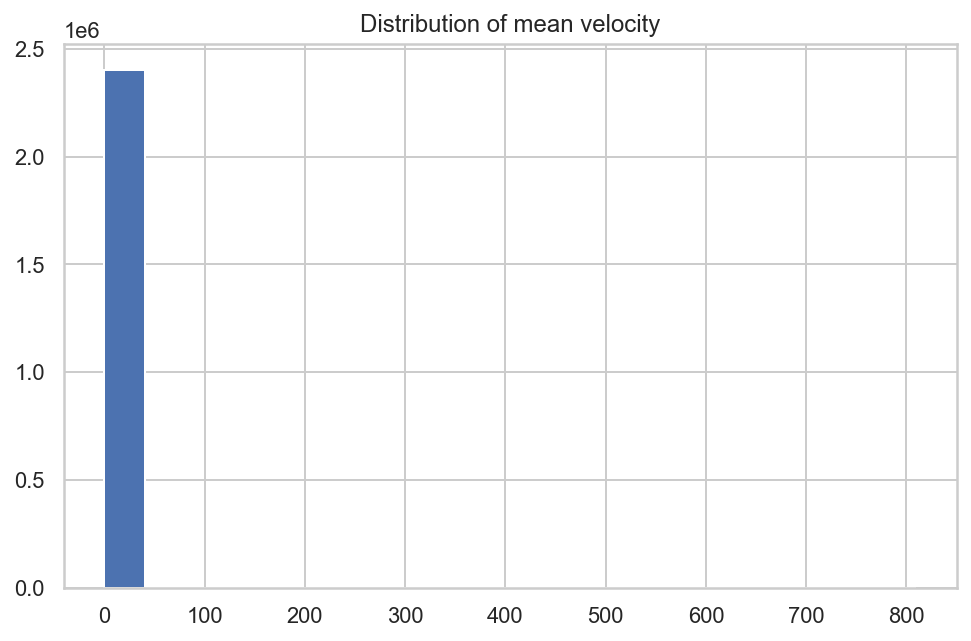

In [75]:
# mean velocity histogram
plt.hist(df['mean_velocity'], bins=20)
plt.title('Distribution of mean velocity')
plt.show()

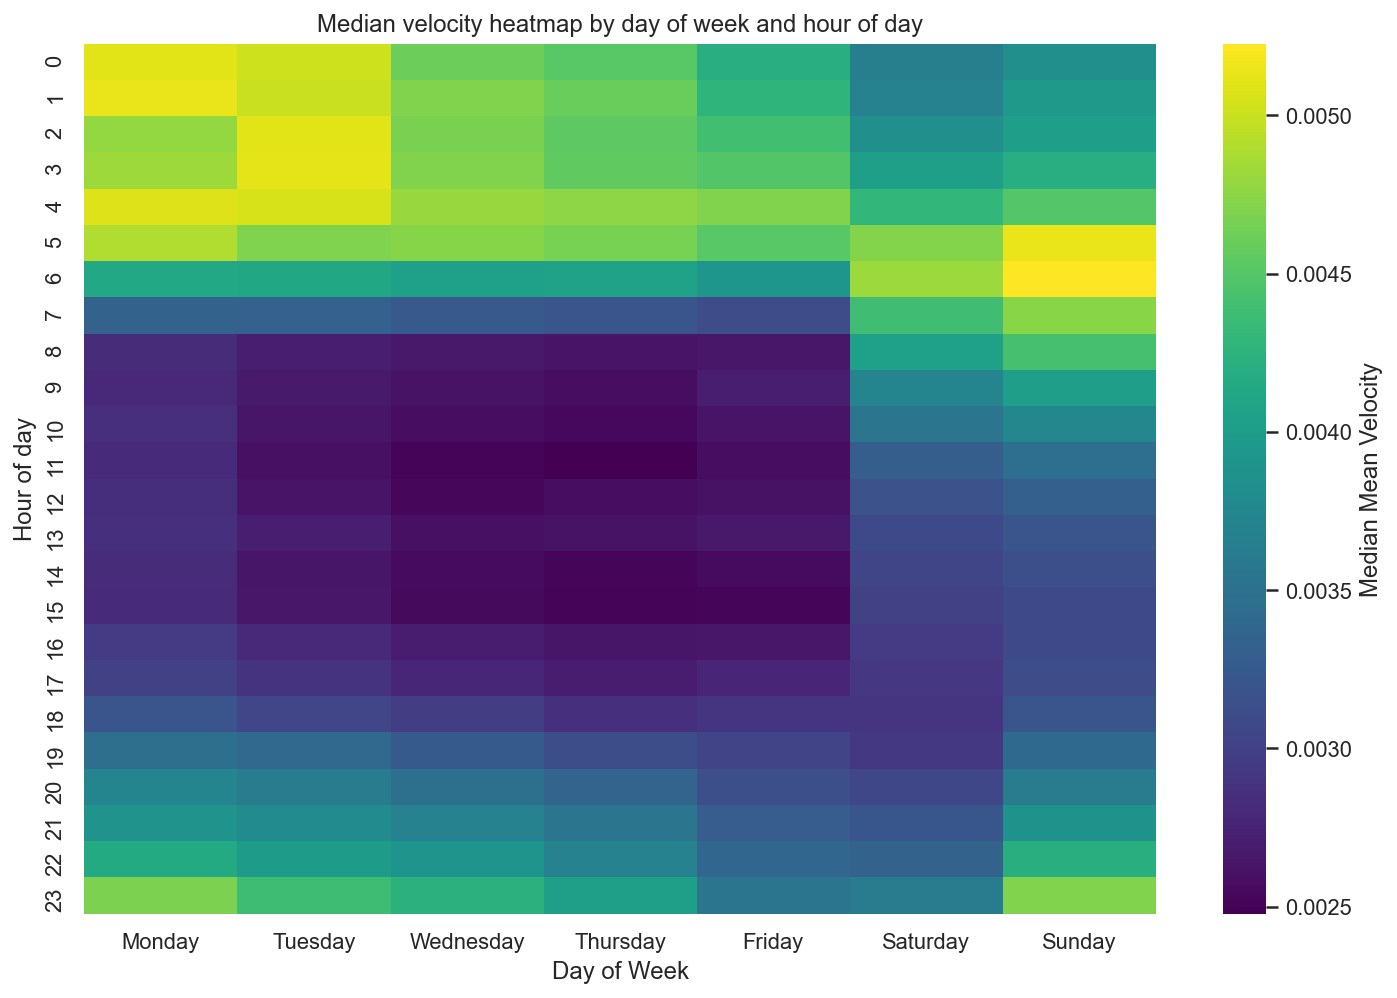

In [54]:
# heatmap of median velocity

# Extract day of the week and hour from the timestamp
df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['hour_of_day'] = df['tpep_pickup_datetime'].dt.hour

# Calculate median of 'mean_velocity' for each combination of day_of_week and hour_of_day
heatmap_data = df.groupby(['day_of_week', 'hour_of_day'])['mean_velocity'].median().reset_index()

# Pivot the DataFrame for the heatmap
heatmap_data = heatmap_data.pivot('hour_of_day', 'day_of_week', 'mean_velocity')

# Define the order of days of the week for proper sorting
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Create the heatmap using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', xticklabels=days_order, cbar_kws={'label': 'Median Mean Velocity'})
plt.title('Median velocity heatmap by day of week and hour of day')
plt.xlabel('Day of Week')
plt.ylabel('Hour of day')
plt.show()